# Triton Examples

## Prerequisites

 * For the test data you will need to install `torch`, `torchvision` and `tensorflow`
 * For the visualization `matplotlib`
 * For calling the service `curl`


## Setup Seldon Core

Follow the instructions to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core).

 Then port-forward to that ingress on localhost:8003 in a separate terminal either with:

 * Ambassador: `kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080`
 * Istio: `kubectl port-forward $(kubectl get pods -l istio=ingressgateway -n istio-system -o jsonpath='{.items[0].metadata.name}') -n istio-system 8003:80`

### Create Namespace for experimentation

We will first set up the namespace of Seldon where we will be deploying all our models

In [1]:
!kubectl create namespace seldon

Error from server (AlreadyExists): namespaces "seldon" already exists


And then we will set the current workspace to use the seldon namespace so all our commands are run there by default (instead of running everything in the default namespace.)

In [2]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_seldon-demos_europe-west1-d_autodeploy" modified.


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

train, test = tf.keras.datasets.cifar10.load_data()
X_test, y_test = test
X_test = X_test.astype('float32') / 255
print(X_test.shape, y_test.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(10000, 32, 32, 3) (10000, 1)


## Triton Model Naming

You need to name the model in the graph with the same name as the triton model loaded as this name will be used in the path to triton.

## Tensorflow CIFAR10 Model


In [1]:
%%writefile resources/triton_tf_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: resnet32
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/tf_resnet32
      name: resnet32
      type: MODEL
    name: default
    replicas: 1
  protocol: kfserving

Writing resources/triton_tf_cifar10.yaml


In [2]:
!kubectl apply -f resources/triton_tf_cifar10.yaml

seldondeployment.machinelearning.seldon.io/resnet32 configured


In [5]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=resnet32 -n seldon -o jsonpath='{.items[0].metadata.name}')

deployment "resnet32-default-0-resnet32" successfully rolled out


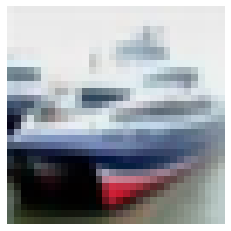

class: ship
prediction: ship


In [23]:
from subprocess import run, Popen, PIPE
import json
import numpy as np
idx=1
test_example=X_test[idx:idx+1].tolist()
payload='{"inputs":[{"name":"input_1","datatype":"FP32","shape":[1, 32, 32, 3],"data":'+f"{test_example}"+'}]}'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/resnet32/v2/models/resnet32/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res=json.loads(raw)
arr=np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[arr.argmax()])

In [24]:
!kubectl delete -f resources/triton_tf_cifar10.yaml

seldondeployment.machinelearning.seldon.io "resnet32" deleted


## ONNX CIFAR10 Model


In [27]:
%%writefile resources/triton_onnx_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/onnx_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: kfserving

Overwriting resources/triton_onnx_cifar10.yaml


In [28]:
!kubectl apply -f resources/triton_onnx_cifar10.yaml

seldondeployment.machinelearning.seldon.io/cifar10 created


In [29]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10 -n seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "cifar10-default-0-cifar10" rollout to finish: 0 of 1 updated replicas are available...
deployment "cifar10-default-0-cifar10" successfully rolled out


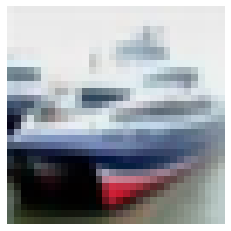

class: ship
prediction: ship


In [31]:
from subprocess import run, Popen, PIPE
import json
import numpy as np
idx=1
test_example=X_test[idx:idx+1].tolist()
payload='{"inputs":[{"name":"input_1:0","datatype":"FP32","shape":[1, 32, 32, 3],"data":'+f"{test_example}"+'}]}'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res=json.loads(raw)
arr=np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[arr.argmax()])

In [32]:
!kubectl delete -f resources/triton_onnx_cifar10.yaml

seldondeployment.machinelearning.seldon.io "cifar10" deleted


## TorchScript CIFAR10 Model


In [41]:
%%writefile resources/triton_pt_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/pytorch_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: kfserving

Overwriting resources/triton_pt_cifar10.yaml


In [42]:
!kubectl apply -f resources/triton_pt_cifar10.yaml

seldondeployment.machinelearning.seldon.io/cifar10 created


In [43]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10 -n seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "cifar10-default-0-cifar10" rollout to finish: 0 of 1 updated replicas are available...
deployment "cifar10-default-0-cifar10" successfully rolled out


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)
for data in testloader:
    images, labels = data
    break

Files already downloaded and verified


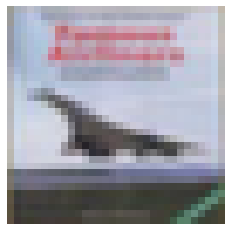

class: airplane
prediction: airplane


In [26]:
from subprocess import run, Popen, PIPE
import json
import numpy as np
idx=3
test_example=images[idx:idx+1]
test_example = test_example.tolist()
payload='{"inputs":[{"name":"input__0","datatype":"FP32","shape":[1, 3, 32, 32],"data":'+f"{test_example}"+'}]}'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res=json.loads(raw)
arr=np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

print("class:",class_names[labels[idx]])
print("prediction:",class_names[arr.argmax()])

In [40]:
!kubectl delete -f resources/triton_pt_cifar10.yaml

seldondeployment.machinelearning.seldon.io "cifar10" deleted
